In [1]:
input_pairs="datasets/pan20-authorship-verification-training-small/prepare/input_pairs.jsonl"
input_truth="datasets/pan20-authorship-verification-training-small/prepare/input_truth.jsonl"
test_pairs="datasets/pan20-authorship-verification-training-small/prepare/test_pairs.jsonl"
seed=42
output="out"
vocab_size=3000
ngram_size=4
num_iterations=0
dropout=0.5

In [2]:
# Imports 

#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
# Naive, Distance-Based Baseline

## Introduction
This baseline offers a naive, yet fast solution to the 
PAN2020 track on authorship verification. All documents
are represented using a bag-of-character-ngrams model,
that is TFIDF weighted. The cosine similarity between
each document pair in the calibration data set is
calculated. Finally, the resulting similarities are
optimized, and projected through a simple rescaling
operation, so that they can function as pseudo-probabi-
lities, indiciating the likelihood that a document-pair
is a same-author pair. Via a grid search, the optimal
verification threshold is determined, taking into account
that some difficult problems can be left unanswered.

Through setting `num_iterations` to an integer > 0,
a bootstrapped variant of this procedure can be used.
In this case, the similarity calculation is applied in
an iterative procedure to a randomly sampled subset of
the available features. The average similarity is then
used downstream. This imputation procedure is inspired
by the imposters approach.

## Dependencies
- Python 3.6+ (we recommend the Anaconda Python distribution)
- scikit-learn, numpy, scipy
- non-essential: tqdm, seaborn/matplotlib
- pan20_verif_evaluator.py

Example usage from the command line:
>>> python pan20-verif-baseline.py \
          -input_pairs="datasets/pan20-authorship-verification-training-small/pairs.jsonl" \
          -input_truth="datasets/pan20-authorship-verification-training-small/truth.jsonl" \
          -test_pairs="datasets/pan20-authorship-verification-test/pairs.jsonl" \
          -num_iterations=0 \
          -output="out"
"""

import argparse
import json
import random
import os
import glob
import shutil
from itertools import combinations

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from seaborn import kdeplot
from tqdm import tqdm

from pan20_verif_evaluator import evaluate_all


In [3]:
# Helper functions
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def rescale(value, orig_min, orig_max, new_min, new_max):
    """
    Rescales a `value` in the old range defined by
    `orig_min` and `orig_max`, to the new range
    `new_min` and `new_max`. Assumes that
    `orig_min` <= value <= `orig_max`.
    Parameters
    ----------
    value: float, default=None
        The value to be rescaled.
    orig_min: float, default=None
        The minimum of the original range.
    orig_max: float, default=None
        The minimum of the original range.
    new_min: float, default=None
        The minimum of the new range.
    new_max: float, default=None
        The minimum of the new range.
    Returns
    ----------
    new_value: float
        The rescaled value.
    """

    orig_span = orig_max - orig_min
    new_span = new_max - new_min

    try:
        scaled_value = float(value - orig_min) / float(orig_span)
    except ZeroDivisionError:
        orig_span += 1e-6
        scaled_value = float(value - orig_min) / float(orig_span)

    return new_min + (scaled_value * new_span)


def correct_scores(scores, p1, p2):
    new_scores = []
    for sc in scores:
        if sc <= p1:
            sc = rescale(sc, 0, p1, 0, 0.49)
            new_scores.append(sc)
        elif sc > p1 and sc < p2:
            new_scores.append(0.5)
        else:
            sc = rescale(sc, p2, 1, 0.51, 1)
            new_scores.append(sc)
    return np.array(new_scores)

In [4]:
# Load data
#     parser = argparse.ArgumentParser(description='Distance-based verification: PAN20 baseline')

#     # data settings:
#     parser.add_argument('-input_pairs', type=str, required=True,
#                         help='Path to the jsonl-file with the input pairs')
#     parser.add_argument('-input_truth', type=str, required=True,
#                         help='Path to the ground truth-file for the input pairs')
#     parser.add_argument('-test_pairs', type=str, required=True,
#                         help='Path to the jsonl-file with the test pairs')
#     parser.add_argument('-output', type=str, required=True,
#                         help='Path to the output folder for the predictions.\
#                              (Will be overwritten if it exist already.)')

#     # algorithmic settings:
#     parser.add_argument('-seed', default=2020, type=int,
#                         help='Random seed')
#     parser.add_argument('-vocab_size', default=3000, type=int,
#                         help='Maximum number of vocabulary items in feature space')
#     parser.add_argument('-ngram_size', default=4, type=int,
#                         help='Size of the ngrams')
#     parser.add_argument('-num_iterations', default=0, type=int,
#                         help='Number of iterations (`k`); zero by default')
#     parser.add_argument('-dropout', default=.5, type=float,
#                         help='Proportion of features to keep in each iteration')

#     args = parser.parse_args()
#     print(args)

    np.random.seed(seed)
    random.seed(seed)

    try:
        shutil.rmtree(output)
    except FileNotFoundError:
        pass
    os.mkdir(output)

    gold = {}
    for line in open(input_truth):
        d = json.loads(line.strip())
        gold[d['id']] = int(d['same'])
    
    # truncation for development purposes
    cutoff = 0
    if cutoff:
        gold = dict(random.sample(gold.items(), cutoff))
        print(len(gold))

    texts = []
    for line in tqdm(open(input_pairs)):
        d = json.loads(line.strip())
        if d['id'] in gold:
            texts.extend(d['pair'])

2000it [00:00, 3028.09it/s]


In [5]:
# 
dict.keys(d)

dict_keys(['id', 'fandoms', 'pair'])

In [6]:
print('-> constructing vectorizer')
vectorizer = TfidfVectorizer(max_features=vocab_size, analyzer='char',
                             ngram_range=(ngram_size, ngram_size))
vectorizer.fit(texts)

-> constructing vectorizer


TfidfVectorizer(analyzer='char', max_features=3000, ngram_range=(4, 4))

# 🚽 break....

In [7]:
if num_iterations:
    total_feats = len(vectorizer.get_feature_names())
    keep_feats = int(total_feats * dropout)

    rnd_feature_idxs = []
    for _ in range(num_iterations):
        rnd_feature_idxs.append(np.random.choice(total_feats,
                                                 keep_feats,
                                                 replace=False))
    rnd_feature_idxs = np.array(rnd_feature_idxs)


In [8]:
print('-> calculating pairwise similarities')
similarities, labels = [], []
for line in tqdm(open(input_pairs)):
    d = json.loads(line.strip())
    if d['id'] in gold:
        x1, x2 = vectorizer.transform(d['pair']).toarray()
        if num_iterations:
            similarities_ = []
            for i in range(num_iterations):
                similarities_.append(cosine_sim(x1[rnd_feature_idxs[i, :]],
                                                x2[rnd_feature_idxs[i, :]]))
            similarities.append(np.mean(similarities_))
        else:
            similarities.append(cosine_sim(x1, x2))
        labels.append(gold[d['id']])

similarities = np.array(similarities, dtype=np.float64)
labels = np.array(labels, dtype=np.float64)



1it [00:00,  6.09it/s]

-> calculating pairwise similarities


2000it [01:20, 24.84it/s]


In [9]:
import pandas as pd
sim_lab = pd.DataFrame([similarities, labels]).transpose()
sim_lab.columns = ["similarity", "label"]
sim_lab.to_csv("similarities.csv")


In [11]:
# let's plot
kdeplot(similarities, label='orig cos sim')

print('-> grid search p1/p2:')
step_size = 0.01
thresholds = np.arange(0.01, 0.99, step_size)
combs = [(p1, p2) for (p1, p2) in combinations(thresholds, 2) if p1 < p2]

params = {}
for p1, p2 in tqdm(combs):
    corrected_scores = correct_scores(similarities, p1=p1, p2=p2)
    score = evaluate_all(pred_y=corrected_scores,
                         true_y=labels)
    params[(p1, p2)] = score['overall']
opt_p1, opt_p2 = max(params, key=params.get)
print('optimal p1/p2:', opt_p1, opt_p2)
plt.axvline(opt_p1, ls='--', c='darkgrey')
plt.axvline(opt_p2, ls='--', c='darkgrey')

corrected_scores = correct_scores(similarities, p1=opt_p1, p2=opt_p2)
print('optimal score:', evaluate_all(pred_y=corrected_scores,
                                     true_y=labels))
kdeplot(corrected_scores, label='corr cos sim')
corr_p1, corr_p2 = correct_scores([opt_p1, opt_p2], p1=opt_p1, p2=opt_p2)
plt.axvline(corr_p1, ls='--', c='darkgrey')
plt.axvline(corr_p2, ls='--', c='darkgrey')
plt.xlim([0, 1])
plt.legend()
plt.tight_layout()
plt.savefig('kde.pdf')
plt.clf()

  0%|          | 2/4753 [00:00<04:14, 18.70it/s]

-> grid search p1/p2:


  2%|▏         | 90/4753 [00:02<01:32, 50.56it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predict

 14%|█▎        | 651/4753 [00:14<02:03, 33.19it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predic

 25%|██▍       | 1179/4753 [00:28<01:37, 36.71it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predi

 35%|███▌      | 1664/4753 [00:37<00:55, 55.72it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predi

 45%|████▍     | 2117/4753 [00:47<00:49, 52.76it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
 45%|████▍     | 2123/4753 [00:48<01:41, 26.03it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter t

 53%|█████▎    | 2536/4753 [01:00<00:45, 48.22it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predi

 61%|██████▏   | 2917/4753 [01:14<00:44, 41.44it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predi

 69%|██████▊   | 3260/4753 [01:23<00:38, 39.01it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
 69%|██████▊   | 3266/4753 [01:24<00:35, 42.26it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter t

 75%|███████▌  | 3570/4753 [01:32<00:30, 38.17it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predi

 81%|████████  | 3844/4753 [01:39<00:21, 42.28it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predi

optimal p1/p2: 0.8200000000000001 0.8400000000000001
optimal score: {'auc': 0.839, 'c@1': 0.783, 'f_05_u': 0.761, 'F1': 0.78, 'overall': 0.791}


<Figure size 432x288 with 0 Axes>

-> determining optimal threshold
Dev results -> F1=0.7705796395518753 at th=0.4882382382382382


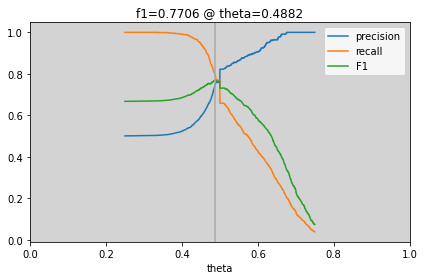

In [12]:
print('-> determining optimal threshold')
scores = []
for th in np.linspace(0.25, 0.75, 1000):
    adjusted = (corrected_scores >= th) * 1
    scores.append((th,
                    f1_score(labels, adjusted),
                    precision_score(labels, adjusted),
                    recall_score(labels, adjusted)))
thresholds, f1s, precisions, recalls = zip(*scores)

max_idx = np.array(f1s).argmax()
max_f1 = f1s[max_idx]
max_th = thresholds[max_idx]
print(f'Dev results -> F1={max_f1} at th={max_th}')

plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.plot(thresholds, f1s, label='F1')
plt.axvline(max_th, ls='-', c='darkgrey')
plt.xlim([0,1])
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.gca().set_facecolor('lightgrey')
plt.title(f'f1={round(max_f1, 4)} @ theta={round(max_th, 4)}')
plt.tight_layout()
plt.savefig('dev_precrec.pdf')


In [ ]:
print('-> calculating test similarities')
with open(output + os.sep + 'answers.jsonl', 'w') as outf:
    for line in tqdm(open(test_pairs)):
        d = json.loads(line.strip())
        problem_id = d['id']
        x1, x2 = vectorizer.transform(d['pair']).toarray()
        if num_iterations:
            similarities_ = []
            for i in range(num_iterations):
                similarities_.append(cosine_sim(x1[rnd_feature_idxs[i, :]],
                                         x2[rnd_feature_idxs[i, :]]))
                similarity = np.mean(similarities_)
        else:
            similarity = cosine_sim(x1, x2)

        similarity = correct_scores([similarity], p1=opt_p1, p2=opt_p2)[0]
        r = {'id': problem_id, 'value': similarity}
        outf.write(json.dumps(r) + '\n')

2it [00:00, 11.87it/s]

-> calculating test similarities


10274it [07:57, 20.58it/s]/Users/shoaib/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
36040it [26:27, 26.35it/s]